In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from gymnasium import spaces
from sklearn.preprocessing import MinMaxScaler

RATES_CSV_PATH = "../data/rates.csv"

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1500)

df = pd.read_csv(RATES_CSV_PATH)
df.set_index('time', inplace=True)

start_datetime = df.index[0]
end_datetime = df.index[-1]
print(f"Data collected from {start_datetime} to {end_datetime}")

df_scaled = df.copy()

scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_scaled), columns=df_scaled.columns, index=df_scaled.index)
df_scaled['unscaled_close'] = df['close']

print(df_scaled.tail())

# Split train/test (80/20)
split_idx = int(len(df) * 0.8)
train_data = df_scaled.iloc[:split_idx]
test_data = df_scaled.iloc[split_idx:]

Data collected from 2024-05-29 20:00:00 to 2025-02-13 18:45:00
                         open      high       low     close    volume  EMA_fast  EMA_medium  EMA_slow      MACD       RSI     Stoch  BB_upper  BB_middle  BB_lower       ATR           OBV      VWAP  unscaled_close
time                                                                                                                                                                                                                
2025-02-13 17:45:00  0.781479  0.768240  0.789698  0.777882  0.351060  0.786009    0.794771  0.800498  0.408712  0.448016  0.422150  0.740315   0.783875  0.796051  0.196392  4.253558e-14  0.784143        95757.02
2025-02-13 18:00:00  0.777937  0.764680  0.786658  0.774957  0.354011  0.785304    0.794304  0.800110  0.401614  0.404719  0.287705  0.740394   0.783660  0.795556  0.194342  4.226816e-14  0.783942        95583.97
2025-02-13 18:15:00  0.775021  0.764411  0.784356  0.777239  0.366289  0.785209    0.

In [5]:
from trade_environment import BitcoinTradingEnv
from stable_baselines3.common.env_util import make_vec_env
import joblib

#seed_value = np.random.randint(0, 100000)
seed_value = 20760
print(f"Using seed: {seed_value}")

env = BitcoinTradingEnv(train_data)
env.action_space.seed(seed_value)
vec_env = make_vec_env(lambda: env, n_envs=1, seed=seed_value)

model = PPO("MlpPolicy", vec_env, verbose=0, n_epochs=10, learning_rate=0.01, ent_coef=0.01, gamma=0.95, clip_range=0.2, batch_size=512, n_steps=4096)
model.learn(total_timesteps=100000, progress_bar=True)
model.save(f"./../results/{seed_value}")
joblib.dump(scaler, f"./../results/{seed_value}.pkl")

Output()

Using seed: 20760


['./../results/20760.pkl']

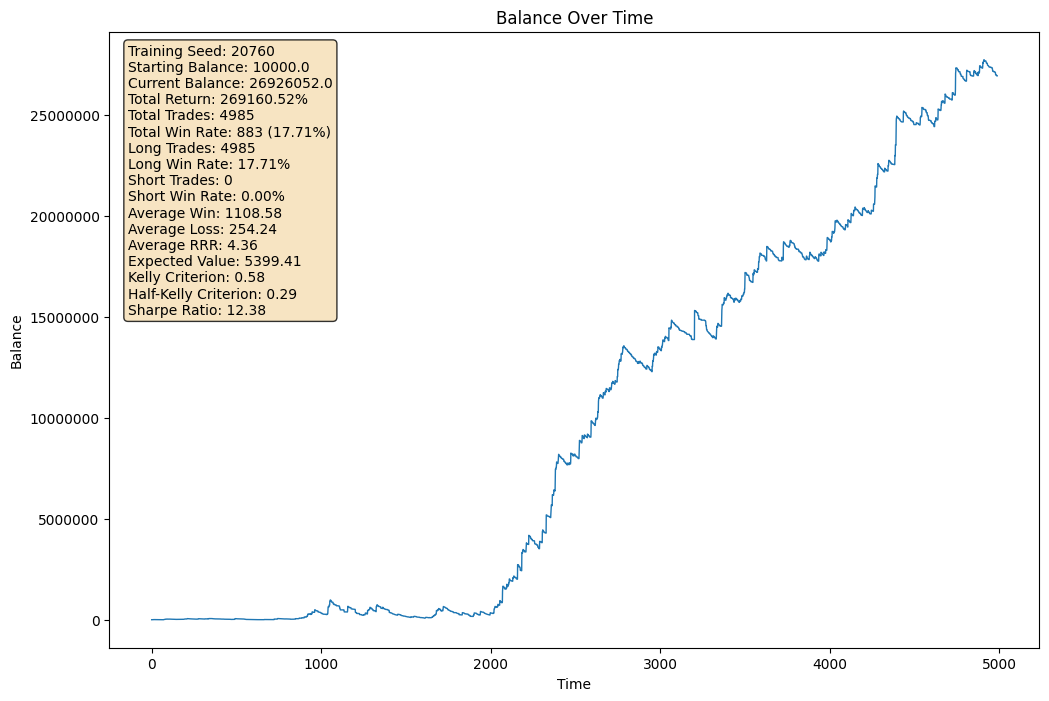

In [6]:
# Instantiate a test environment using test_data
test_env = BitcoinTradingEnv(test_data, initial_balance=10000.0)
test_env.action_space.seed(seed_value)

# Reset the test environment and get initial observation
obs, info = test_env.reset()

balance_over_time = []
actions_log = []
done = False

while not done:
    action, _ = model.predict(obs, deterministic=True)
    actions_log.append(action)
    obs, reward, done, truncated, info = test_env.step(action)
    balance_over_time.append(test_env.balance)

# Convert the list of completed trades to a DataFrame
trades_df = pd.DataFrame(test_env.trades)

def classify_trade(row):
    # For a long trade (position == 1): TP when exit > entry, SL otherwise.
    # For a short trade (position == -1): TP when exit < entry, SL otherwise.
    if row["position"] == 1:
        return "TP" if row["exit"] > row["entry_price"] else "SL"
    elif row["position"] == -1:
        return "TP" if row["exit"] < row["entry_price"] else "SL"
    else:
        return "Unknown"

trades_df["trade_type"] = trades_df.apply(classify_trade, axis=1)

total_trades = len(trades_df)
num_tp = trades_df[trades_df["trade_type"] == "TP"].shape[0]
num_sl = trades_df[trades_df["trade_type"] == "SL"].shape[0]

perc_tp = (num_tp / total_trades * 100) if total_trades > 0 else 0.0
perc_sl = (num_sl / total_trades * 100) if total_trades > 0 else 0.0

avg_pnl_tp = trades_df[trades_df["trade_type"] == "TP"]["pnl"].mean() if num_tp > 0 else 0.0
avg_pnl_sl = trades_df[trades_df["trade_type"] == "SL"]["pnl"].mean() if num_sl > 0 else 0.0

# Compute a basic Sharpe ratio using trade pnl as returns (assume risk-free rate = 0)
returns = trades_df["pnl"]
if returns.std() > 0:
    sharpe_ratio = returns.mean() / returns.std() * np.sqrt(len(returns))
else:
    sharpe_ratio = np.nan

total_return = ((test_env.balance - test_env.initial_balance) / test_env.initial_balance) * 100
expected_value = trades_df["pnl"].mean() if total_trades > 0 else 0.0

# Compute mean win and mean loss using absolute difference between exit and entry prices and trade_type
trades_df["abs_diff"] = abs(trades_df["exit"] - trades_df["entry_price"])
mean_win = trades_df[trades_df["trade_type"] == "TP"]["abs_diff"].mean() if not trades_df[trades_df["trade_type"] == "TP"].empty else 0.0
mean_loss = trades_df[trades_df["trade_type"] == "SL"]["abs_diff"].mean() if not trades_df[trades_df["trade_type"] == "SL"].empty else 0.0

num_buy = trades_df[trades_df["position"] == 1].shape[0]
num_sell = trades_df[trades_df["position"] == -1].shape[0]

buy_win_rate = trades_df[(trades_df["position"] == 1) & (trades_df["trade_type"] == "TP")].shape[0] / num_buy * 100 if num_buy > 0 else 0.0
sell_win_rate = trades_df[(trades_df["position"] == -1) & (trades_df["trade_type"] == "TP")].shape[0] / num_sell * 100 if num_sell > 0 else 0.0

rrr = mean_win / mean_loss if mean_loss > 0 else 0.0
kelly_criteria = (rrr * perc_tp / 100) - (perc_sl / 100) / rrr

plt.figure(figsize=(12, 8))
ax = plt.gca()

# Plot balance over time using real time from test_data
ax.plot(balance_over_time, linewidth=1, linestyle='-')
ax.set_xlabel("Time")
ax.set_ylabel("Balance")
ax.set_title("Balance Over Time")
ax.ticklabel_format(style='plain', axis='y')

# Build multiline string for performance metrics
metrics_text = (
    f"Training Seed: {seed_value}\n"
    f"Starting Balance: {test_env.initial_balance}\n"
    f"Current Balance: {test_env.balance}\n"
    f"Total Return: {total_return:.2f}%\n"
    f"Total Trades: {total_trades}\n"
    f"Total Win Rate: {num_tp} ({perc_tp:.2f}%)\n"
    f"Long Trades: {num_buy}\n"
    f"Long Win Rate: {buy_win_rate:.2f}%\n"
    f"Short Trades: {num_sell}\n"
    f"Short Win Rate: {sell_win_rate:.2f}%\n"
    f"Average Win: {mean_win:.2f}\n"
    f"Average Loss: {mean_loss:.2f}\n"
    f"Average RRR: {rrr:.2f}\n"
    f"Expected Value: {expected_value:.2f}\n"
    f"Kelly Criterion: {kelly_criteria:.2f}\n"
    f"Half-Kelly Criterion: {kelly_criteria / 2:.2f}\n"
    f"Sharpe Ratio: {sharpe_ratio:.2f}"
)

# Add annotation box in the upper left-hand corner (legend-like)
ax.text(0.02, 0.98, metrics_text, transform=ax.transAxes,
        fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.savefig(f"./../results/{seed_value}.png")
plt.show()